# Introduction


**What?** Quantile regression with application in pyTorch_2



# Import modules

In [1]:
from functools import partial
from itertools import chain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 20
np.random.seed(1)

# Create dataset

In [2]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

X.shape, y.shape, xx.shape

((100, 1), (100,), (1000, 1))

In [3]:
X

array([[4.1702199e+00],
       [7.2032452e+00],
       [1.1437482e-03],
       [3.0233257e+00],
       [1.4675589e+00],
       [9.2338592e-01],
       [1.8626021e+00],
       [3.4556072e+00],
       [3.9676747e+00],
       [5.3881674e+00],
       [4.1919451e+00],
       [6.8521948e+00],
       [2.0445225e+00],
       [8.7811747e+00],
       [2.7387592e-01],
       [6.7046752e+00],
       [4.1730480e+00],
       [5.5868983e+00],
       [1.4038694e+00],
       [1.9810148e+00],
       [8.0074453e+00],
       [9.6826162e+00],
       [3.1342418e+00],
       [6.9232264e+00],
       [8.7638912e+00],
       [8.9460669e+00],
       [8.5044211e-01],
       [3.9054784e-01],
       [1.6983042e+00],
       [8.7814255e+00],
       [9.8346835e-01],
       [4.2110763e+00],
       [9.5788956e+00],
       [5.3316526e+00],
       [6.9187713e+00],
       [3.1551564e+00],
       [6.8650093e+00],
       [8.3462563e+00],
       [1.8288277e-01],
       [7.5014434e+00],
       [9.8886108e+00],
       [7.481656

# Build the model

In [4]:
class q_model(nn.Module):
    def __init__(self, 
                 quantiles, 
                 in_shape=1,  
                 dropout=0.5):     
        super().__init__()
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = len(quantiles)
        self.dropout = dropout
        self.build_model()
        self.init_weights()
        
    def build_model(self): 
        self.base_model = nn.Sequential(
            nn.Linear(self.in_shape, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
            nn.Linear(64, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
        )
        final_layers = [
            nn.Linear(64, 1) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def init_weights(self):
        for m in chain(self.base_model, self.final_layers):
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)        
        
    def forward(self, x):
        tmp_ = self.base_model(x)
        return torch.cat([layer(tmp_) for layer in self.final_layers], dim=1)

In [5]:
class q_model_simplified(nn.Module):
    def __init__(self, 
                 quantiles, 
                 in_shape=1,  
                 dropout=0.5):     
        super().__init__()
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = len(quantiles)
        self.dropout = dropout
        self.build_model()
        self.init_weights()
        
    def build_model(self): 
        self.model = nn.Sequential(
            nn.Linear(self.in_shape, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
            nn.Linear(64, 128),
            nn.ReLU(),
            # nn.BatchNorm1d(128),
            nn.Dropout(self.dropout),
            nn.Linear(128, self.out_shape)
        )
        
    def init_weights(self):
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)        
        
    def forward(self, x):
        return self.model(x)

In [6]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss

In [7]:
class Learner:
    def __init__(self, model, optimizer_class, loss_func, device='cpu'):
        self.model = model.to(device)
        self.optimizer = optimizer_class(self.model.parameters())
        self.loss_func = loss_func.to(device)
        self.device = device
        self.loss_history = []

    def fit(self, x, y, epochs, batch_size):
        self.model.train()
        for e in range(epochs):
            shuffle_idx = np.arange(x.shape[0])
            np.random.shuffle(shuffle_idx)
            x = x[shuffle_idx]
            y = y[shuffle_idx]
            epoch_losses = []
            for idx in range(0, x.shape[0], batch_size):
                self.optimizer.zero_grad()
                batch_x = torch.from_numpy(
                    x[idx: min(idx + batch_size, x.shape[0]), :]
                ).float().to(self.device).requires_grad_(False)
                batch_y = torch.from_numpy(
                    y[idx: min(idx + batch_size, y.shape[0])]
                ).float().to(self.device).requires_grad_(False)
                preds = self.model(batch_x)
                loss = loss_func(preds, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.cpu().detach().numpy())
            epoch_loss = np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if (e+1) % 500 == 0:
                print("Epoch {}: {}".format(e+1, epoch_loss))

    def predict(self, x, mc=False):
        if mc:
            self.model.train()
        else:
            self.model.eval()
        return self.model(torch.from_numpy(x).to(self.device).requires_grad_(False)).cpu().detach().numpy()

In [11]:
# Instantiate model
quantiles = [.05, .5, .95]
model = q_model(quantiles, dropout=0.1)
loss_func = QuantileLoss(quantiles)
#learner = Learner(model, partial(torch.optim.Adam, weight_decay=1e-6), loss_func, device="cuda:0")
learner = Learner(model, partial(torch.optim.Adam, weight_decay=1e-6), loss_func)

In [4]:
X.shape

(100, 1)

In [5]:
y.shape

(100,)

# Train the model

In [12]:
# Run training
epochs = 10000
learner.fit(X, y, epochs, batch_size=10)

Epoch 500: 1.7810837030410767
Epoch 1000: 1.8190921545028687
Epoch 1500: 1.3551735877990723
Epoch 2000: 1.2596757411956787
Epoch 2500: 1.1695501804351807
Epoch 3000: 1.16835618019104
Epoch 3500: 1.3152366876602173
Epoch 4000: 1.2230517864227295
Epoch 4500: 1.18644118309021
Epoch 5000: 1.2071648836135864
Epoch 5500: 1.1537468433380127
Epoch 6000: 1.1731938123703003
Epoch 6500: 1.161199688911438
Epoch 7000: 1.1255054473876953
Epoch 7500: 1.0704289674758911
Epoch 8000: 1.1079325675964355
Epoch 8500: 1.1409704685211182
Epoch 9000: 1.0798407793045044
Epoch 9500: 1.111851692199707
Epoch 10000: 1.122779130935669


In [16]:
# Make the prediction on the meshed x-axis
tmp = learner.predict(xx)
y_lower, y_pred, y_upper = tmp[:, 0], tmp[:, 1], tmp[:, 2]

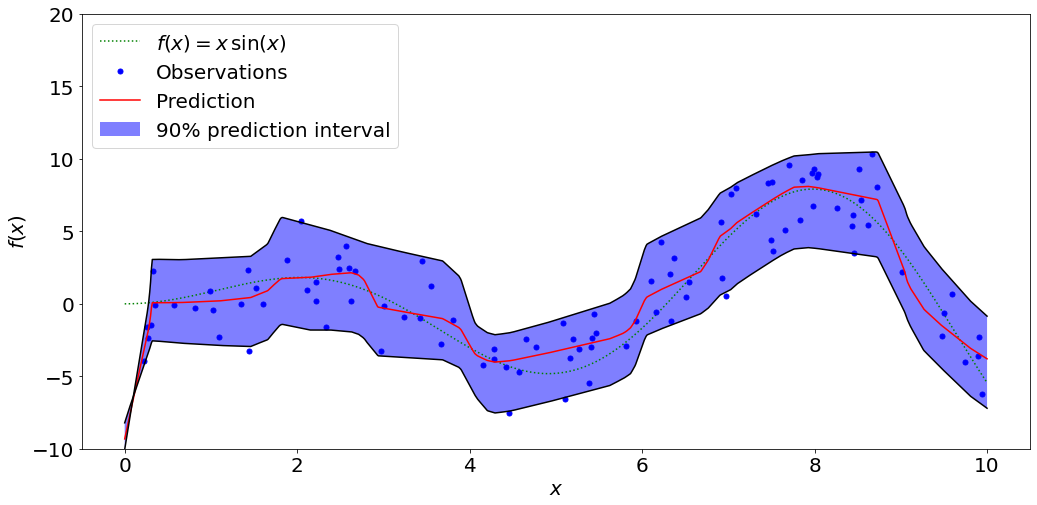

In [17]:
# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

# References
<hr style="border:2px solid black"> </hr>


- - https://github.com/ceshine/quantile-regression-tensorflow/blob/master/notebooks/03-sklearn-example-pytorch.ipynb<br>

